# AI Generated Image Detector

En este notebook se detalla todo el proceso de entrenamiento de un modelo del `Computer Vision` capaz de detectar imágenes generadas con herramientas de `IA generativa`

# 1. Dataset

In [1]:
# !pip install opencv-python

El dataset utilizado

In [17]:
import kagglehub
import os
import pandas as pd

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split, Dataset

from tqdm import tqdm  # Importar tqdm

from PIL import Image

In [3]:
# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [01:20<00:00, 130MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [4]:
os.listdir(path)

['train_data', 'test.csv', 'test_data_v2', 'train.csv']

# Análisis de los datos

In [5]:
data = pd.read_csv(os.path.join(path, "train.csv"), index_col=0)

In [6]:
data.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [7]:
def show_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

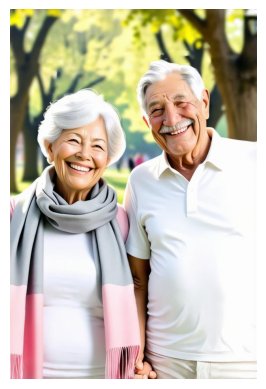

In [8]:
show_image(os.path.join(path, data.iloc[0]["file_name"]))

# 2. Modeling

## 1. Preparación de Datos y Transformaciones


In [9]:
# Creamos el dataset
class AIvsHumanDataset(Dataset):
    def __init__(self, images_dir, labels_file, transform=None):
        """
        images_dir  : carpeta que contiene las imágenes
        labels_file : ruta a un archivo que asocia cada imagen con su etiqueta
        transform   : transformaciones opcionales (transform.Compose) a aplicar
        """
        self.images_dir = images_dir
        self.transform = transform

        # Cargar nombres de archivo e etiquetas desde el archivo labels_file
        # labels_file puede ser un CSV, JSON, o texto plano
        # Supongamos un CSV con columnas: [filename, label]
        self.img_labels = []
        with open(labels_file, "r") as f:
            next(f)  # saltar la primera fila si es un CSV con encabezados
            for line in f:
                _, filename, label = line.strip().split(",")
                self.img_labels.append((filename, int(label)))  # convertir label a entero si es clasificación numérica

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 1. Obtener ruta de la imagen y etiqueta
        img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.images_dir, img_name)

        # 2. Cargar imagen usando Pillow (PIL)
        image = Image.open(img_path).convert("RGB")

        # 3. Aplicar transformaciones (si existen)
        if self.transform:
            image = self.transform(image)

        # 4. Retornar los datos
        return image, label


In [10]:
# Definir transformaciones para los datos (ejemplo para imágenes en escala de grises)
transform = transforms.Compose([
    transforms.Resize((512, 768)),
    transforms.ToTensor(), # Convertir imagen a torch.Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalización con media=0.5 y std=0.5
])

In [11]:
# Creamos split de entrenamiento y validación

# 1. Instancia del dataset con todas las muestras
full_dataset = AIvsHumanDataset(
    images_dir=path,
    labels_file=os.path.join(path, "train.csv"),
    transform=transform
)

# 2. Definir tamaños de split
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)   # 80% para train
val_size = int(0.2 * dataset_size)     # 20% para validación

# 3. Partición aleatoria
train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

In [12]:
# Definir DataLoaders para manejar lotes (batches)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=24, shuffle=False)

## 2. Definición del Modelo

In [13]:
train_dataset[0][0].shape

torch.Size([3, 512, 768])

In [14]:
class MiModelo(nn.Module):
    def __init__(self):
        super(MiModelo, self).__init__()

        # Primera capa convolucional: 3 canales (RGB) -> 32 filtros, kernel 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Normalización y dropout para evitar sobreajuste
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.5)

        # Capa de pooling para reducir tamaño
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Cálculo automático del tamaño final para `fc1`
        self.flatten_size = self._get_flatten_size()

        # Capa totalmente conectada
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.fc2 = nn.Linear(256, 2)  # Salida binaria

    def _get_flatten_size(self):
        """Función auxiliar para calcular el tamaño de entrada de `fc1`."""
        dummy_input = torch.randn(1, 3, 512, 768)  # Imagen de prueba con tamaño original
        x = self.pool(F.relu(self.batchnorm1(self.conv1(dummy_input))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        return x.numel()  # Devuelve el número total de elementos después del flatten

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))

        # Aplanamos la salida de la convolución
        x = torch.flatten(x, start_dim=1)

        # Capa totalmente conectada + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Capa de salida con activación Sigmoid
        x = torch.sigmoid(self.fc2(x))

        return x

model = MiModelo()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MiModelo(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=786432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [15]:
# torch.cuda.empty_cache()

In [16]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
torch.cuda.is_available()

True

## 3. Definir la Función de Pérdida y el Optimizador

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. Ciclo de Entrenamiento (Training Loop)


In [19]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

num_epochs = 5  # definir cuántas épocas se quieren entrenar
checkpoint_dir = '/content/drive/MyDrive/checkpoints'  # Ruta en Drive
os.makedirs(checkpoint_dir, exist_ok=True)  # Crear el directorio si no existe


Mounted at /content/drive


In [21]:
# Ruta al checkpoint que deseas cargar
checkpoint_path = '/content/drive/MyDrive/checkpoints/checkpoint_epoch_1.pth'  # Ajusta la ruta y el nombre del archivo

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path)

# Restaurar el estado del modelo
model.load_state_dict(checkpoint['model_state_dict'])

# Restaurar el estado del optimizador
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Restaurar la época actual
start_epoch = checkpoint['epoch']

# Restaurar la pérdida (opcional)
loss = checkpoint['loss']

print(f'Checkpoint cargado desde: {checkpoint_path}, Época: {start_epoch}, Pérdida: {loss}')


<ipython-input-21-349e11289382>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint cargado desde: /content/drive/MyDrive/checkpoints/checkpoint_epoch_1.pth, Época: 1, Pérdida: 0.6932703586501431


In [22]:

num_epochs = 5  # definir cuántas épocas se quieren entrenar

for epoch in range(start_epoch, num_epochs):
    model.train()  # modo entrenamiento
    running_loss = 0.0

    # Añadir tqdm para la barra de progreso
    progress_bar = tqdm(train_loader, desc=f"Epoca {epoch+1}/{num_epochs}", leave=False)

    for images, labels in progress_bar:
        # Move images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)  # Mover a GPU si está disponible

        # 1. Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 2. Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Mostrar la pérdida actual en la barra de progreso
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # Calcular la pérdida promedio por época
    epoch_loss = running_loss / len(train_loader)

    print(f"Epoca [{epoch+1}/{num_epochs}], Perdida (loss): {epoch_loss:.4f}")

    # Guardar checkpoint al final de cada época
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, checkpoint_path)
    print(f'Checkpoint guardado en: {checkpoint_path}')

Epoca [2/5], Perdida (loss): 0.6932
Checkpoint guardado en: /content/drive/MyDrive/checkpoints/checkpoint_epoch_2.pth


Epoca [3/5], Perdida (loss): 0.6931
Checkpoint guardado en: /content/drive/MyDrive/checkpoints/checkpoint_epoch_3.pth


Epoca [4/5], Perdida (loss): 0.6931
Checkpoint guardado en: /content/drive/MyDrive/checkpoints/checkpoint_epoch_4.pth


Epoca [5/5], Perdida (loss): 0.6931
Checkpoint guardado en: /content/drive/MyDrive/checkpoints/checkpoint_epoch_5.pth


In [ ]:
# num_epochs = 5  # definir cuántas épocas se quieren entrenar

# for epoch in range(num_epochs):
#     model.train()  # modo entrenamiento
#     running_loss = 0.0

#     for images, labels in train_loader:
#         # 1. Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # 2. Backward pass y optimización
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # Calcular la pérdida promedio por época
#     epoch_loss = running_loss / len(train_loader)

#     print(f"Época [{epoch+1}/{num_epochs}], Pérdida (loss): {epoch_loss:.4f}")


## 5. Evaluación del Modelo


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Mover a GPU si está disponible
        outputs = model(images)
        # outputs tiene forma [batch_size, num_clases], se elige la clase con mayor probabilidad
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Exactitud (accuracy) en el conjunto de test: {accuracy:.2f}%")


Exactitud (accuracy) en el conjunto de test: 49.94%


# Conclusiones

El modelo que se ha entrenado ha obtenido una accuracy de un 50% sobre un problema de clasificación binario. Esto quiere decir que está realizando una predicción casi pseudoaleatoria. El entrenamiento del modelo ha llevado 6h y pare ello se han empleado máquinas premium del colab. Por esta misma razón no valoro un segundo reentrenamiento.